In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import subprocess as sp
from tqdm import tqdm 
import gtfparse

import seaborn as sns
import sys

sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from plot_gtf import *

In [8]:
import tabix
from pybedtools import BedTool

def read_EF(gene, K):
    EF = pd.read_csv(f'ebpmf_models/tables/{gene}/ebpmf_K{str(K)}/EF.tab.gz', sep='\t', index_col=0)
    EF_smooth = pd.read_csv(f'ebpmf_models/tables/{gene}/ebpmf_K{str(K)}/EF_smooth.tab.gz', sep='\t', index_col=0)
    col_names = [f'factor{str(i+1)}' for i in range(K)]
    EF.columns = col_names
    EF_smooth.columns = col_names

    EF = EF.iloc[1:(len(EF)-1)]
    EF_smooth = EF_smooth.iloc[1:(len(EF_smooth)-1)]
    EF_smooth.index = EF.index
    
    return EF_smooth

def smooth_EF(EF):
    
    EF_smooth = pd.DataFrame()
    for factor in EF.columns:
        f_smooth = smooth_factor(EF[factor])
        EF_smooth[factor] = f_smooth
        
    EF_smooth.index = EF.index
    
    
    return EF_smooth

# def smooth_factor(factor, cutoff=0.25, smooth_fraction = 0.25, step_fraction = 10, exon_quant = 0.99, cutoff_strict = 0.1):
#     factor = factor/(np.quantile(factor, exon_quant))
#     step =int(len(factor)/step_fraction)
        
#     factor_smooth = []
#     for idx, f in enumerate(factor):
#         if f <= cutoff_strict:
#             f_smooth = 0
            
#         if (idx >= 1) and (factor_smooth[idx-1] == 0) and (f < cutoff):
#             f_smooth = 0
#         elif (idx < step) :
            
#             if (idx < 100):
            
#                 if (f < cutoff):
#                     f_smooth = 0
#                 else:
#                     f_smooth = 1
#             else:
#                 f_ref = idx-100
#                 f_last = idx-1

#                 f_exon_peak = np.quantile(factor[f_ref:f_last], exon_quant)
                
#                 if (f < (f_exon_peak*smooth_fraction)):
#                     f_smooth = 0
#                 else:
#                     f_smooth = 1
                
#         elif (idx > step):
#             f_ref = idx-step
#             f_last = idx-1
            
#             f_exon_peak = np.quantile(factor[f_ref:f_last], exon_quant)
            
#             if (f < (f_exon_peak*smooth_fraction)):
#                 f_smooth = 0
#             else:
#                 f_smooth = 1
#         else:
#             f_smooth = 1
            
#         factor_smooth.append(f_smooth)
        
#     for idx, f in reversed(list(enumerate(factor))):
#         if idx < (len(factor)-step):
#             previous_f = factor_smooth[idx+1]
#             if (previous_f == 1) and (f > (f_exon_peak*smooth_fraction)):
#                 factor_smooth[idx] = 1
    
#     factor_smooth = np.array(factor_smooth)
    
#     return factor_smooth

In [339]:
def get_factor_shift(gene, K):
    EF = read_EF(gene, K)
    EF_smooth = smooth_EF(EF)
    EF_shift = (EF_smooth - EF_smooth.shift(-1)).fillna(0)
    return EF, EF_smooth, EF_shift

def make_factor_junctions_bed(EF_shift, factor='factor1'):
    
    EF_shift = EF_shift.loc[EF_shift[factor] != 0]
    
    open_ = False
    bed_factor = pd.DataFrame()
    chrom_list = []
    start_list = []
    end_list = []

    for idx, row in EF_shift.iterrows():
        if row[factor] == 1:
            chrom_, start_ = idx.split(':')
            start_ = int(start_)
            open_ = True
            chrom_list.append(chrom_)
            start_list.append(start_)
        elif (row[factor] == -1) and open_:
            chrom_, end_ = idx.split(':')
            end_ = int(end_)
            end_list.append(end_)

    factor_junctions_bed = pd.DataFrame([chrom_list, start_list, end_list]).T.dropna()
    factor_junctions_bed = BedTool.from_dataframe(factor_junctions_bed)
    
    return factor_junctions_bed

def run_tabix(factor):
    
    onepercent = int(len(factor)/100)
    
    chrom_ = factor.chrom
    start_ = int(factor.start) - 50
    end_ = int(factor.start) + 50

    tb = tabix.open('junctions.tab.gz')
    juncs = tb.query(chrom_, start_, end_)
    
    return juncs

def get_overlapping_junctions_bed(factor):
    
    juncs = run_tabix(factor)
    
    df = pd.DataFrame()

    for idx, record in enumerate(juncs):
        df[f'record{str(idx)}'] = record[:-1]

    df = df.T
    overlapping_junctions_bed = BedTool.from_dataframe(df)
    
    return overlapping_junctions_bed

def make_junction_directory(idx, factor_junction, matching_junction):
    distance_start = np.abs(int(matching_junction.start) - int(factor_junction.start))
    distance_end = np.abs(int(matching_junction.end) - int(factor_junction.end))
    total_distance = distance_start + distance_end

    median_counts = np.quantile([int(x) for x in matching_junction.fields[4:]], 0.95)

    junction_dict_idx = {idx:{
        'start':int(matching_junction.start),
        'end':int(matching_junction.end),
        'distance':total_distance,
        'counts':median_counts
    }}
    
    return junction_dict_idx

def get_best_junction(factor_junction, intersection):
    
    junction_dict = {}
    
    for idx, matching_junction in enumerate(intersection):
        junction_dict_idx = make_junction_directory(idx, factor_junction, matching_junction)
        junction_dict.update(junction_dict_idx)
#         distance_start = np.abs(int(row.start) - int(factor_junction.start))
#         distance_end = np.abs(int(row.end) - int(factor_junction.end))
#         total_distance = distance_start + distance_end
        
#         median_counts = np.median([int(x) for x in row.fields[4:]])
        
#         junction_dict.update({idx:{
#             'start':int(row.start),
#             'end':int(row.end),
#             'distance':total_distance,
#             'counts':median_counts
#         }})
    
    current_junc = None
    for idx, junc in junction_dict.items():
        if (junc['distance'] < 100) and (junc['counts'] > 20):
            if current_junc:
                if (junc['distance'] < current_junc['distance']):
                    current_junc = junc
                else:
                    continue
            else:
                current_junc = junc
                
    return current_junc
        

def get_factor_junctions(factor_junctions_bed):
    
    junctions_match_list = []
    
    for factor_junction in factor_junctions_bed:
        
        overlapping_junctions_bed = get_overlapping_junctions_bed(factor_junction)
        intersection = overlapping_junctions_bed.intersect(factor_junctions_bed, f=0.9, r=True, wa=True)
        
        if len(intersection) == 0:
            junctions_match_list.append(None)
        else:
            best_junc = get_best_junction(factor_junction, intersection)
            junctions_match_list.append(best_junc)
            
    return junctions_match_list
#             print('junc1')
            
#             for row in intersection:
#                 print(int(row.start) - int(factor_junction.start))
#                 print(int(row.end) - int(factor_junction.end))
#                 counts = [int(x) for x in row.fields[4:]]
#                 print(np.median(counts))
#             print('')
            
def function_to_collect_junctions_and_fix_annotation():
    pass

In [10]:
# def get_EF_smooth(gene, k):
#     EF = read_EF(gene, k)
#     EF_smooth = smooth_EF(EF)
#     return EF_smooth

# def get_EF_shift(EF_smooth, factor):
#     EF_shift = (EF_smooth - EF_smooth.shift(-1)).fillna(0)
#     EF_shift = EF_shift.loc[EF_shift[factor] != 0]
#     return EF_shift

def get_factor_bed(EF_shift, factor):
    open_ = False
    bed_factor = pd.DataFrame()
    chrom_list = []
    start_list = []
    end_list = []

    for idx, row in EF_shift.iterrows():
        if row[factor] == 1:
            chrom_, start_ = idx.split(':')
            start_ = int(start_)
            open_ = True
            chrom_list.append(chrom_)
            start_list.append(start_)
        elif (row[factor] == -1) and open_:
            chrom_, end_ = idx.split(':')
            end_ = int(end_)
            end_list.append(end_)

    bed_factors_df = pd.DataFrame([chrom_list, start_list, end_list]).T.dropna()
    bed_factors = BedTool.from_dataframe(bed_factors_df)
    
    return bed_factors_df, bed_factors

In [11]:
# def correct_factor(EF, EF_smooth, EF_shift, factor, factor_junctions, bed_factors_df):
    
#     corrected_factor = []
    
#     current_junc_pos = 0
#     current_junc = factor_junctions[current_junc_pos]
#     factor_gap = bed_factors_df.iloc[current_junc_pos]
    
#     start_gap = 
    
#     for idx, row in EF_smooth:
#         chrom, current_bp = idx.split(':')
#         current_bp = int(current_bp)
#         if not current_junc:
#             if (current_bp < factor_gap[1]) or (current_bp > factor_gap[2]):
#                 corrected_factor_bp = int(row[factor])
#             else:
                

In [152]:
def correct_factor(EF, EF_smooth, EF_shift, factor, factor_junctions, bed_factors_df, exon_quant = 0.99):
    
    EF_norm = EF/EF[factor].quantile(exon_quant)
    
    
    corrected_factor = []
    
    idx_covered = []
    
    
#     first_pos = len(EF[factor])
    
    for current_junc_pos, current_junc in enumerate(factor_junctions):
        
        factor_gap = bed_factors_df.iloc[current_junc_pos]
        chrom_gap = factor_gap[0]
        start_gap = int(factor_gap[1])
        end_gap = int(factor_gap[2])
        
        
        if current_junc:
            start_junc = current_junc['start']
            end_junc = current_junc['end']
            junc_length = end_junc - start_junc
            gap_coverage = [0]*junc_length
            
            junc_idx = [f'{chrom_gap}:{str(x)}' for x in range(start_junc, end_junc)]
            
        
        
        else:
            start_junc = start_gap
            end_junc = end_gap
            
            gap_length = end_gap - start_gap
            
            start_coverage_gap = start_gap - gap_length
            
            start_coverage = int(EF_shift.iloc[current_junc_pos].name.split(':')[1])
            
#             print(start_coverage)
#             print(start_gap)
            start_coverage = np.max([start_coverage_gap, start_coverage])
            
            exon_idx = [f'{chrom_gap}:{str(x)}' for x in range(start_coverage, start_gap)]
            gap_idx = [f'{chrom_gap}:{str(x)}' for x in range(start_gap, end_gap)]
            
            
            exon_median = EF_norm.loc[exon_idx, factor].median()
            intron_median = EF_norm.loc[gap_idx, factor].median()
            
            junc_idx = gap_idx
            
            if intron_median > (exon_median*0.25):
                gap_coverage = [1]*len(gap_idx)
#                 print(list(EF_smooth.loc[gap_idx, factor]))
            else:
#                 print(gap_idx)
#                 print(type(gap_idx))
                gap_coverage = list(EF_smooth.loc[gap_idx, factor])
                
        if current_junc_pos == 0:
            _, first_pos = EF_smooth.index[0].split(':')
            first_pos = int(first_pos)
            idx_5p = [f'{chrom_gap}:{str(x)}' for x in range(first_pos, start_junc)]
            EF_5p = list(EF_smooth.loc[idx_5p, factor])
            for i, bp in reversed(list(enumerate(EF_5p))):
                if bp == 0:
                    EF_5p[i] = 1
                else:
                    break
            corrected_factor.extend(EF_5p)
            last_exon_5p = end_junc
            idx_covered.extend(idx_5p)
            
#             print(len(EF_5p))
#             print(len(idx_5p))
            
            
        else:
            len_exon_5p = start_junc - last_exon_5p
            exon_5p = [1]*len_exon_5p
            corrected_factor.extend(exon_5p)
            
            idx_5p = [f'{chrom_gap}:{str(x)}' for x in range(last_exon_5p, start_junc)]
            last_exon_5p = end_junc
            
            
            
            idx_covered.extend(idx_5p)
            
#             print(len(exon_5p))
#             print(len(idx_5p))
            
            
        idx_covered.extend(junc_idx)
            
        corrected_factor.extend(gap_coverage)
        
#         print(len(gap_coverage))
#         print(len(junc_idx))
        
        
        
        if current_junc_pos == (len(factor_junctions)-1):
            _, last_pos = EF_smooth.index[-1].split(':')
            last_pos = int(last_pos)+1
            idx_3p = [f'{chrom_gap}:{str(x)}' for x in range(end_junc, last_pos)]
            EF_3p = list(EF_smooth.loc[idx_3p, factor])
            
            for i, bp in enumerate(EF_3p):
                if bp == 0:
                    EF_3p[i] = 1
                else:
                    break
            
            
            corrected_factor.extend(EF_3p)
            idx_covered.extend(idx_3p)
            
#             print(len(EF_3p))
#             print(len(idx_3p))

    corrected_factor = np.array(corrected_factor)
            
    return corrected_factor, idx_covered
            


In [349]:
def smooth_factor(factor, cutoff_=0.25, smooth_fraction = 0.25, step_fraction = 10, exon_quant = 0.99, cutoff_strict = 0.1):
    
    cutoff = cutoff_
    
    factor = factor/(np.quantile(factor, exon_quant))
    step =int(len(factor)/step_fraction)
        
    factor_smooth = []
    last_pos = None
    for idx, f in enumerate(factor):

        if f <= cutoff_strict:
            factor_smooth.append(0)
            last_pos = None
            continue
            
        if (idx == 0):
            if (f > cutoff):
                f_smooth = 1
                last_pos = 0
            else:
                f_smooth = 0
                last_pos = None
                
            
        else:
            
            if (factor_smooth[idx-1] == 0):
                if (f < cutoff):
                    f_smooth = 0
                    last_pos = None
                else:
                    f_smooth = 1
                    last_pos = idx
            else:
                last_pos = np.max([last_pos, (idx-100)])
                f_exon_peak = np.quantile(factor[last_pos:idx], exon_quant)
                
                if (f < (f_exon_peak*smooth_fraction)):
                    f_smooth = 0
                    cutoff = np.max([f, cutoff_])
                    last_pos = None
                else:
                    f_smooth = 1
                
                
        
        factor_smooth.append(f_smooth)
        
    last_pos = None
    for idx, f in reversed(list(enumerate(factor))):
        
        if (idx == (len(factor) - 1)):
            if (factor_smooth[idx]==1):
                last_pos = len(factor) - 1
            else:
                continue
        
        else:
            
            previous_f = factor_smooth[idx+1]
            current_f = factor_smooth[idx]
            
            if (previous_f == 0) and (current_f == 1):
                last_pos = idx
                continue
            
            elif (previous_f == 1):
                last_pos = np.min([last_pos, (idx+100)])
                
                if (current_f == 0) and (last_pos - idx) < 10:
                    # Remove small peaks that can be from mapping errors
                    for j in range(idx, last_pos+1):
                        factor_smooth[j] = 0
                    continue
                
                f_exon_peak = np.quantile(factor[(idx+1):(last_pos+1)], exon_quant)
                
                if (f > (f_exon_peak*smooth_fraction)):
                    factor_smooth[idx] = 1
                else:
                    continue
#                     f_smooth = 0
#                     last_pos = None
#                 else:
#                     f_smooth = 1
                
                
                
                
#                 (f > (f_exon_peak*smooth_fraction)):
#                 factor_smooth[idx] = 1
    
    factor_smooth = np.array(factor_smooth)
    
    return factor_smooth

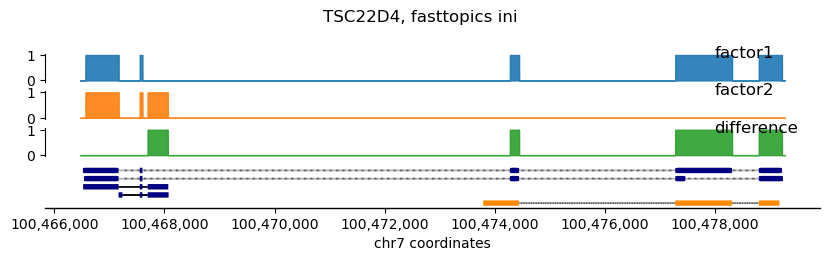

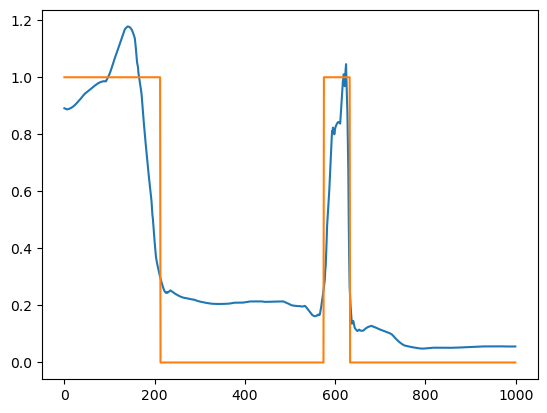

In [350]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000166925', 2)
plot_factors(corrected_EF, 2, 'ENSG00000166925', difference=True)

plt.plot(np.array(EF.factor1)[500:1500]/np.quantile(np.array(EF.factor1), 0.99))
plt.plot(np.array(EF_smooth.factor1)[500:1500])

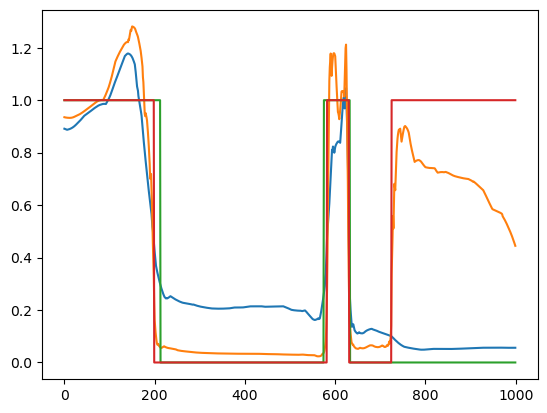

In [352]:
plt.plot(np.array(EF.factor1)[500:1500]/np.quantile(np.array(EF.factor1), 0.99))
plt.plot(np.array(EF.factor2)[500:1500]/np.quantile(np.array(EF.factor2), 0.99))

plt.plot(np.array(EF_smooth.factor1)[500:1500])
plt.plot(np.array(EF_smooth.factor2)[500:1500])

In [342]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000166925', 3)


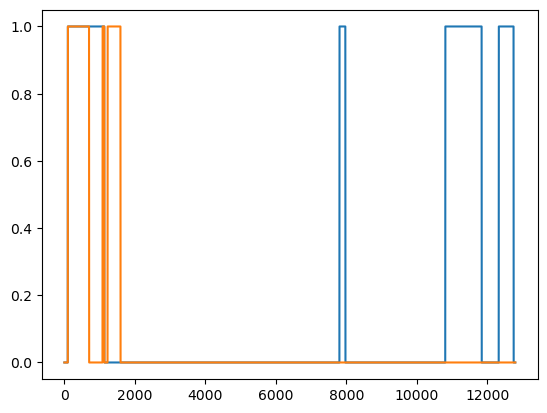

In [345]:
plt.plot(np.array(corrected_EF.factor1))
plt.plot(np.array(corrected_EF.factor2))

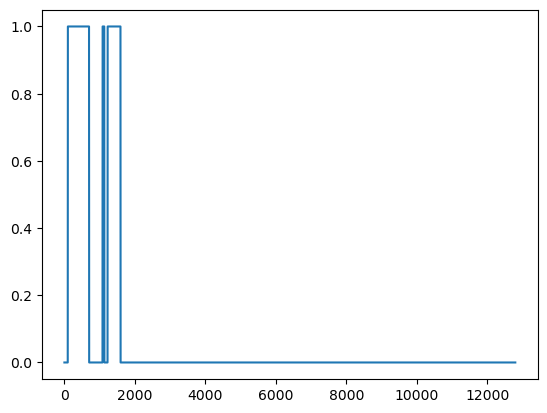

In [346]:
plt.plot(np.array(corrected_EF.factor3))

In [341]:
def get_factors_stm(gene, k):
    
    EF, EF_smooth, EF_shift = get_factor_shift(gene, k)
    
    corrected_EF = pd.DataFrame()

    for i in range(1, k+1):
        factor = f'factor{str(i)}'
        factor_junctions_bed = make_factor_junctions_bed(EF_shift, factor=factor)
        junctions_match_list = get_factor_junctions(factor_junctions_bed)
        bed_factors_df, _ = get_factor_bed(EF_shift, factor)
        corrected_factor, idx_covered = correct_factor(
            EF, EF_smooth, EF_shift, factor, junctions_match_list, bed_factors_df)
        
        corrected_EF[factor] = corrected_factor
        
    corrected_EF.index = EF.index
    
    return EF, EF_smooth, corrected_EF
        


In [156]:
# EF1, EF_smooth1, EF_shift1 = get_factor_shift('ENSG00000109917', 2)
# factor_junctions_bed1 = make_factor_junctions_bed(EF_shift1, factor='factor1')
# junctions_match_list1 = get_factor_junctions(factor_junctions_bed1)

# bed_factors_df1, _ = get_factor_bed(EF_shift1, 'factor1')
# corrected_EF1, idx_covered = correct_factor(EF1, EF_smooth1, EF_shift1, 'factor1', junctions_match_list1, bed_factors_df1)

# EF2, EF_smooth2, EF_shift2 = get_factor_shift('ENSG00000109917', 2)
# factor_junctions_bed2 = make_factor_junctions_bed(EF_shift2, factor='factor2')
# junctions_match_list2 = get_factor_junctions(factor_junctions_bed2)

# bed_factors_df2, _ = get_factor_bed(EF_shift2, 'factor2')
# corrected_EF2, idx_covered = correct_factor(EF2, EF_smooth2, EF_shift2, 'factor2', junctions_match_list2, bed_factors_df2)

In [202]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000109917', 2)

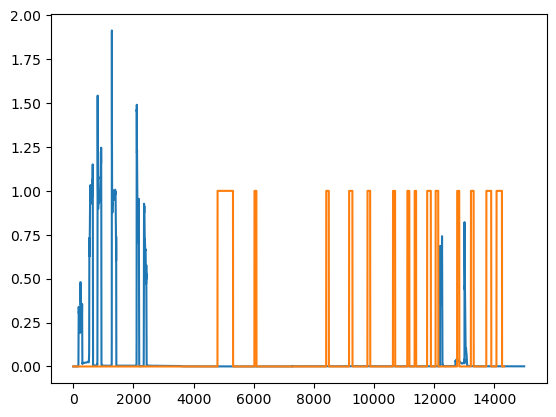

In [203]:
# plt.plot(np.array(EF1.factor1)/EF1.factor1.quantile(0.99))
plt.plot(np.array(EF1.factor1)/EF1.factor1.quantile(0.99))

# plt.plot(np.array(EF_smooth1.factor1)/5)
plt.plot(np.array(corrected_EF.factor1))

# plt.plot([0, 300], [0.1, 0.1])

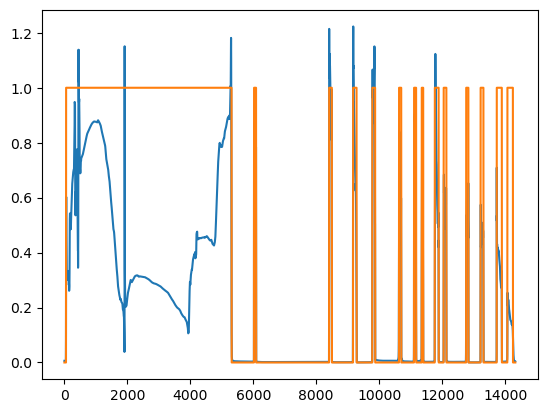

In [204]:
# plt.plot(np.array(EF1.factor1)/EF1.factor1.quantile(0.99))
plt.plot(np.array(EF.factor2)/EF.factor2.quantile(0.99))

# plt.plot(np.array(EF_smooth1.factor1)/5)
plt.plot(np.array(corrected_EF.factor2))

# plt.plot([0, 300], [0.1, 0.1])

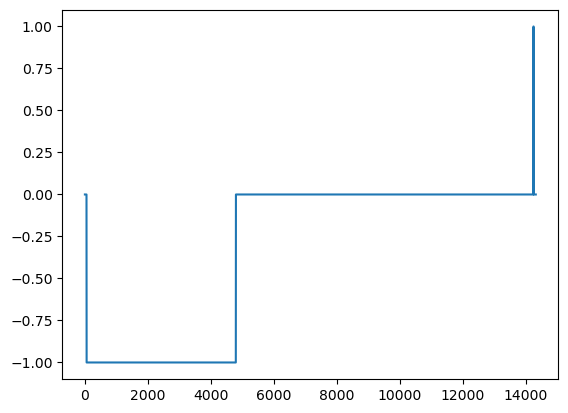

In [205]:
plt.plot(np.array(corrected_EF.factor1) - np.array(corrected_EF.factor2))

In [206]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000196531', 2)

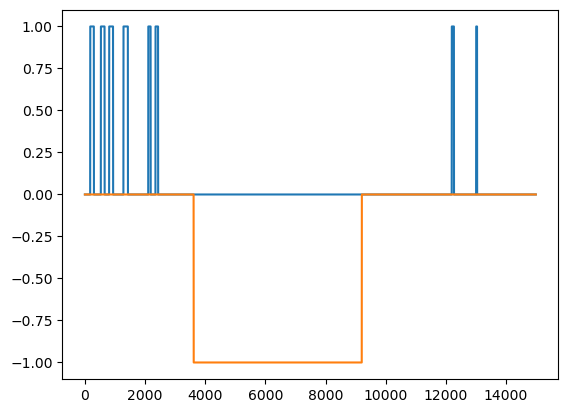

In [207]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000196531', 2)
plt.plot(np.array(corrected_EF.factor1))

plt.plot(np.array(corrected_EF.factor1) - np.array(corrected_EF.factor2))

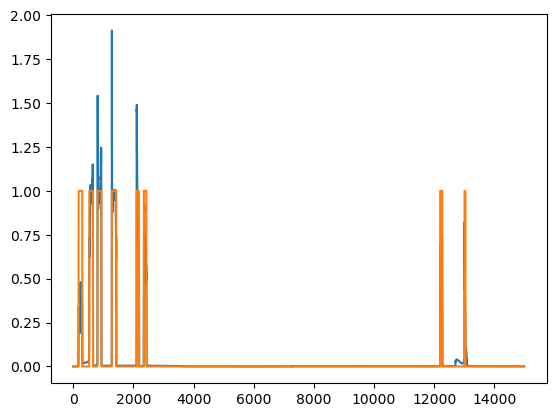

In [208]:
# plt.plot(np.array(EF1.factor1)/EF1.factor1.quantile(0.99))
plt.plot(np.array(EF.factor1)/EF.factor1.quantile(0.99))

# plt.plot(np.array(EF_smooth1.factor1)/5)
plt.plot(np.array(corrected_EF.factor1))

# plt.plot([0, 300], [0.1, 0.1])

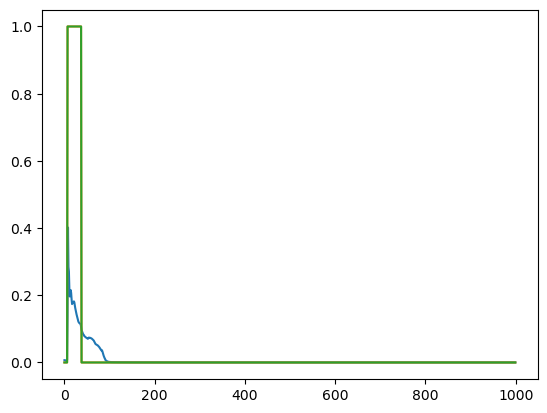

In [210]:
# plt.plot(np.array(EF1.factor1)/EF1.factor1.quantile(0.99))
plt.plot(np.array(EF.factor2)[13000:14000]/EF.factor2.quantile(0.99))

# plt.plot(np.array(EF_smooth1.factor1)/5)
plt.plot(np.array(corrected_EF.factor2)[13000:14000])
plt.plot(np.array(EF_smooth.factor2)[13000:14000])
# plt.plot([0, 300], [0.1, 0.1])

In [182]:
# EF1, EF_smooth1, EF_shift1 = get_factor_shift('ENSG00000196531', 2)
factor_junctions_bed1 = make_factor_junctions_bed(EF_shift1, factor='factor2')
junctions_match_list1 = get_factor_junctions(factor_junctions_bed1)

In [199]:
tb = tabix.open('junctions.tab.gz')
juncs = tb.query('chr12', 56714685, 56715868)

In [200]:
for i in juncs:
    print(i[:4])
    print(np.median([int(x) for x in i[4:] if (x != '')]))
    print(np.quantile([int(x) for x in i[4:] if (x != '')], 0.95))
    print('')

['chr12', '56714676', '56724451', 'ENSG00000196531.10']
99.0
234.0

['chr12', '56714688', '56715870', 'ENSG00000196531.10']
4.0
803.9500000000007

['chr12', '56714688', '56719536', 'ENSG00000196531.10']
4.0
17.0

['chr12', '56714688', '56724451', 'ENSG00000196531.10']
1958.0
4582.950000000001

['chr12', '56714704', '56724451', 'ENSG00000196531.10']
4.0
12.0



In [185]:
for i in factor_junctions_bed1:
    print(i)

chr12	56712551	56712786

chr12	56712908	56713059

chr12	56713189	56713535

chr12	56713683	56714360

chr12	56714438	56714600

chr12	56714685	56715868

chr12	56721460	56724450

chr12	56724518	56725261



In [ ]:
    chrom_ = factor.chrom
    start_ = int(factor.start) - 50
    end_ = int(factor.start) + 50

    tb = tabix.open('junctions.tab.gz')
    juncs = tb.query(chrom_, start_, end_)
    


In [183]:
junctions_match_list1

[{'start': 56712553, 'end': 56712785, 'distance': 3, 'counts': 1819.0},
 {'start': 56712909, 'end': 56713061, 'distance': 3, 'counts': 3441.0},
 {'start': 56713191, 'end': 56713536, 'distance': 3, 'counts': 3674.0},
 {'start': 56713684, 'end': 56714361, 'distance': 2, 'counts': 2868.0},
 {'start': 56714440, 'end': 56714601, 'distance': 3, 'counts': 2830.0},
 None,
 None,
 {'start': 56724524, 'end': 56725262, 'distance': 7, 'counts': 1635.0}]

In [187]:
EF1, EF_smooth1, EF_shift1 = get_factor_shift('ENSG00000109917', 2)
factor_junctions_bed1 = make_factor_junctions_bed(EF_shift1, factor='factor1')
junctions_match_list1 = get_factor_junctions(factor_junctions_bed1)

bed_factors_df1, _ = get_factor_bed(EF_shift1, 'factor1')
corrected_EF1, idx_covered = correct_factor(EF1, EF_smooth1, EF_shift1, 'factor1', junctions_match_list1, bed_factors_df1)

Index(['chr11:116773749', 'chr11:116773750', 'chr11:116773751',
       'chr11:116773752', 'chr11:116773753', 'chr11:116773754',
       'chr11:116773755', 'chr11:116773756', 'chr11:116773757',
       'chr11:116773758',
       ...
       'chr11:116788063', 'chr11:116788064', 'chr11:116788065',
       'chr11:116788066', 'chr11:116788067', 'chr11:116788068',
       'chr11:116788069', 'chr11:116788070', 'chr11:116788071',
       'chr11:116788072'],
      dtype='object', name='coords', length=14324)

In [216]:
len(idx_covered)

14324

In [146]:
[x for x in idx_covered if x not in EF_smooth.index]

[]

In [148]:
[x for x in idx_covered if idx_covered.count(x) > 1]

[]

In [217]:
[x for x in EF_smooth.index if x not in idx_covered]

[]

In [138]:
EF1, EF_smooth1, EF_shift1 = get_factor_shift('ENSG00000112081', 2)
factor_junctions_bed1 = make_factor_junctions_bed(EF_shift1, factor='factor1')
junctions_match_list1 = get_factor_junctions(factor_junctions_bed1)

bed_factors_df1, _ = get_factor_bed(EF_shift1, 'factor1')
corrected_EF1, idx_covered = correct_factor(EF1, EF_smooth1, EF_shift1, 'factor1', junctions_match_list1, bed_factors_df1)

EF2, EF_smooth2, EF_shift2 = get_factor_shift('ENSG00000112081', 2)
factor_junctions_bed2 = make_factor_junctions_bed(EF_shift2, factor='factor2')
junctions_match_list2 = get_factor_junctions(factor_junctions_bed2)

bed_factors_df2, _ = get_factor_bed(EF_shift2, 'factor2')
corrected_EF2, idx_covered = correct_factor(EF2, EF_smooth2, EF_shift2, 'factor2', junctions_match_list2, bed_factors_df2)

In [103]:
bed_factors_df1

,0,1,2
0,chr6,36594479,36596759
1,chr6,36596967,36598847
2,chr6,36598982,36601155
3,chr6,36601189,36601706
4,chr6,36601792,36601963


In [135]:
bed_factors_df2

,0,1,2
0,chr6,36594475,36596760
1,chr6,36596967,36598848
2,chr6,36598983,36599803
3,chr6,36600284,36601150
4,chr6,36601192,36601705
5,chr6,36601803,36601959


In [116]:
junctions_match_list1

[{'start': 36594482, 'end': 36596760, 'distance': 4, 'counts': 359.5},
 {'start': 36596969, 'end': 36598848, 'distance': 3, 'counts': 470.0},
 {'start': 36598984, 'end': 36601151, 'distance': 6, 'counts': 222.0},
 {'start': 36601191, 'end': 36601707, 'distance': 3, 'counts': 483.0},
 {'start': 36601795, 'end': 36601961, 'distance': 5, 'counts': 567.0}]

In [117]:
junctions_match_list2

[{'start': 36594482, 'end': 36596760, 'distance': 7, 'counts': 359.5},
 {'start': 36596969, 'end': 36598848, 'distance': 2, 'counts': 470.0},
 {'start': 36598984, 'end': 36599820, 'distance': 18, 'counts': 111.0},
 {'start': 36600277, 'end': 36601151, 'distance': 8, 'counts': 135.0},
 {'start': 36601191, 'end': 36601707, 'distance': 3, 'counts': 483.0},
 {'start': 36601795, 'end': 36601961, 'distance': 10, 'counts': 567.0}]

In [102]:
bed_factors_df2

,0,1,2
0,chr6,36594475,36596760
1,chr6,36596967,36598848
2,chr6,36598983,36599803
3,chr6,36600284,36601150
4,chr6,36601192,36601705
5,chr6,36601803,36601959


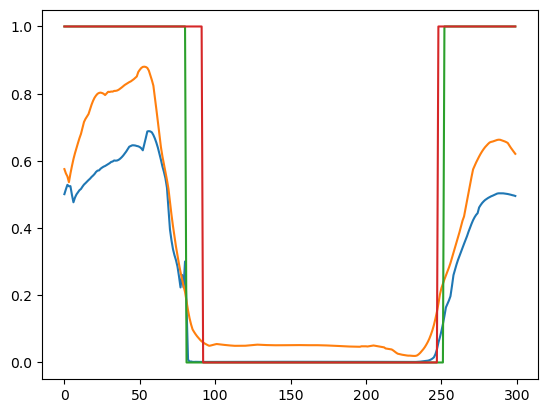

In [118]:
plt.plot(np.array(EF1.factor1)[7400:7700]/np.max(np.array(EF1.factor1)))

plt.plot(np.array(EF2.factor2)[7400:7700]/np.max(np.array(EF2.factor2)))

plt.plot(np.array(EF_smooth1.factor1)[7400:7700]/np.max(np.array(EF_smooth1.factor1)))
plt.plot(np.array(EF_smooth2.factor2)[7400:7700]/np.max(np.array(EF_smooth2.factor2)))

# plt.plot(corrected_EF1)

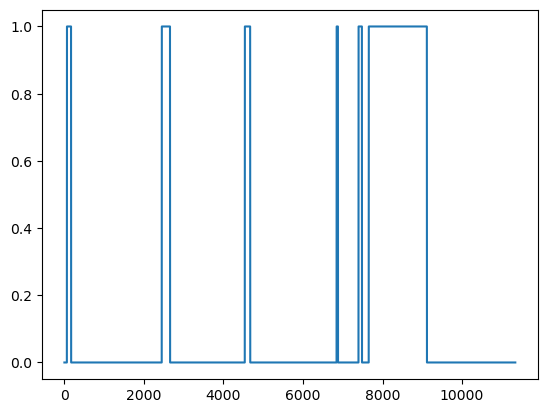

In [139]:
plt.plot(np.array(EF_smooth1.factor1))


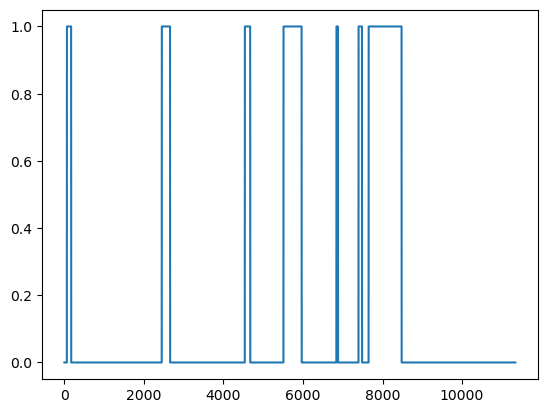

In [140]:
# plt.plot(np.array(EF2.factor2)/np.max(np.array(EF2.factor2)))

plt.plot(np.array(corrected_EF2))

# plt.plot(corrected_EF2)

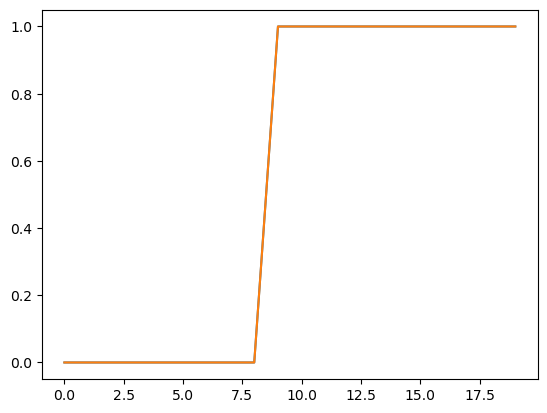

In [141]:
plt.plot((np.array(corrected_EF1))[7640:7660])

plt.plot((np.array(corrected_EF2))[7640:7660])


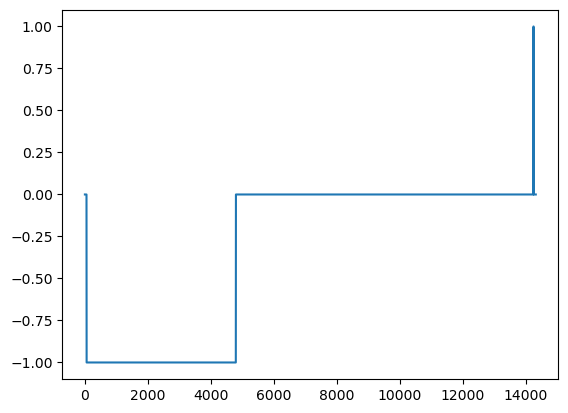

In [153]:
plt.plot(np.array(corrected_EF1) - np.array(corrected_EF2))

In [226]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import subprocess as sp
from tqdm import tqdm 
import gtfparse

import seaborn as sns
import sys

sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from plot_gtf import *

def get_gene_gtf(gtf_df, gene):
    try:
        gtf_gene = gtf_df.loc[gtf_df.gene_id==gene]
    except:
        gtf_gene = gtf_df.loc[gtf_df.gene_name==gene]
    gtf_exons = gtf_gene.loc[gtf_gene.feature=='exon']
    strand = gtf_gene.strand.iloc[0]
    
    if strand == '+':
        start = gtf_gene.loc[gtf_gene.feature=='start_codon'].start.min()
        stop = gtf_gene.loc[gtf_gene.feature=='stop_codon'].end.max()
    else:
        start = gtf_gene.loc[gtf_gene.feature=='stop_codon'].start.min()
        stop = gtf_gene.loc[gtf_gene.feature=='start_codon'].end.max()
    
    cds = (start, stop)
    
    return gtf_exons, cds

# # Load GTF file
gtf_file = 'Annotations/gencode.v34.primary_assembly.annotation.gtf'#'Annotations/gencode.v43.basic.annotation.gtf'

# # Parse GTF file to DataFrame
gtf_df = gtfparse.read_gtf(gtf_file)

gtf_df.gene_id = [x.split('.')[0] for x in gtf_df.gene_id]

def plot_gene(EF, gtf, gene, K, title=None, difference = False):
    gtf_exons, cds = get_gene_gtf(gtf_df, gene)
    colores = sns.color_palette("tab10")
    
    if difference:
        nrows = K+2
    else:
        nrows = K+1
    
#     if K == 2:
#         S = 4*0.75
    if K <= 3:
        S = K
    else:
        S = K*0.8
    
    fig, ax = plt.subplots(nrows = nrows, figsize=(10, S), gridspec_kw={'height_ratios': [2]*(nrows-1) + [3], 
                                                                           'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]/np.max(EF[factor])
        ax[i].fill_between(coords,[0]*len(scaled_y), scaled_y, color=colores[i], alpha=0.9)
        ax[i].set_xticks([])
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        
        ax[i].text(start+((end-start)*0.9), 0.9, factor, size=12)
        
    i = 2
    if difference:
        factor = 'difference'
        scaled_y = np.abs(np.array(EF.factor1) - np.array(EF.factor2))
        ax[i].fill_between(coords, [0]*len(scaled_y), scaled_y, color=colores[i], alpha=0.9)
        ax[i].set_xticks([])
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        
        ax[i].text(start+((end-start)*0.9), 0.9, factor, size=12)
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    PlotGene(gtf_exons, plot_cds=False, collapse_transcripts=False, plot_nmd=True, ax=ax[nrows-1])
    ax[nrows-1].set_xlim(ax[0].get_xlim())
    
#     plt.show()
def plot_coverage(gene, gtf, counts, tissue_list, title=None, log=True):
    gtf_exons, cds = get_gene_gtf(gtf_df, gene)
    colores = sns.color_palette("tab10")
    
#     tissues = sorted(os.listdir('coverage/counts_tables/'))
    
    fig, ax = plt.subplots(nrows = (len(tissue_list)+1), figsize=(10, len(tissue_list)), 
                           gridspec_kw={'height_ratios': [2]*len(tissue_list) + [3], 
                                                                           'wspace': 0.3, 'hspace': 0.3})
    if log:
        counts = np.log1p(counts)

    start = int(counts.columns[0].split(':')[1])
    end = int(counts.columns[-1].split(':')[1])
    length = counts.shape[1]

    coords = np.linspace(start, end, num=length)
    
    for i, tissue in enumerate(tissue_list):
        
        tissue_idx = samples.loc[samples.tissue_id==tissue].index.intersection(counts.index)
    
        for idx, row in counts.loc[tissue_idx].iterrows():
            y = np.array(row)
            
            scaled_y = y/np.max(y)
            ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.2, rasterized=True)
        
        ax[i].set_xticks([])
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        
        if log:
            ax[i].set_ylabel('log1p\ncounts', size=9)
        else:
            ax[i].set_ylabel('counts', size=9)
        
        ax[i].text(start+((end-start)*0.65), 0.9, tissue, size=12)
        
    if title:
        fig.suptitle(title, fontsize=12)
    

    PlotGene(gtf_exons, plot_cds=False, collapse_transcripts=False, plot_nmd=True, ax=ax[len(tissue_list)])
    ax[len(tissue_list)].set_xlim(ax[0].get_xlim())
    
#     plt.show()


#         if smooth:
#             plt.savefig(f'/project2/yangili1/cfbuenabadn/stm_top/plots/{gene}.K{str(K)}.factors_smooth.png', 
#                         dpi=500, bbox_inches='tight')
#         else:
#             plt.savefig(f'/project2/yangili1/cfbuenabadn/stm_top/plots/{gene}.K{str(K)}.factors.png', 
#                         dpi=500, bbox_inches='tight')
    

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [217]:
def plot_factors(EF, K, gene, difference=False):
    
    gtf_exons, cds = get_gene_gtf(gtf_df, gene)
    gene_name = gtf_df.loc[gtf_df.gene_id==gene].gene_name.iloc[0]
    plot_gene(EF, gtf_df, gene, K, f'{gene_name}, fasttopics ini', difference=difference)
    plt.show()

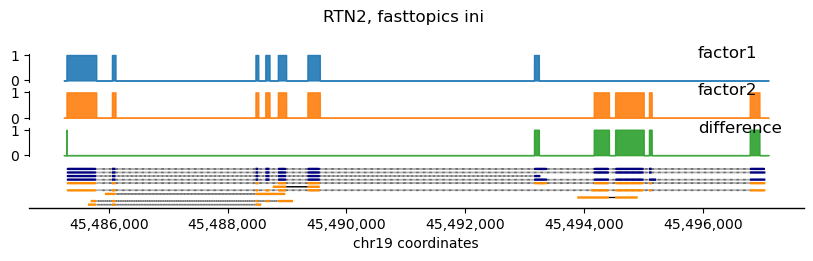

In [353]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000125744', 2)

plot_factors(corrected_EF, 2, 'ENSG00000125744', difference=True)


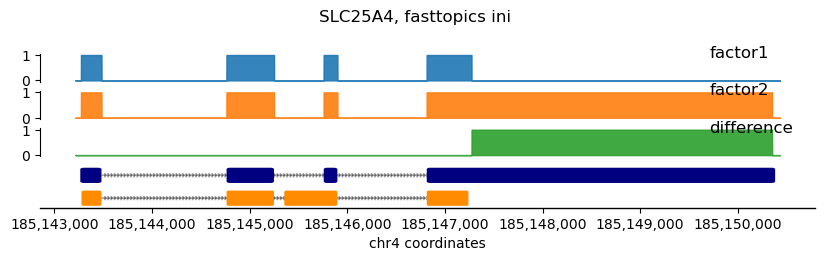

In [354]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000151729', 2)

plot_factors(corrected_EF, 2, 'ENSG00000151729', difference=True)


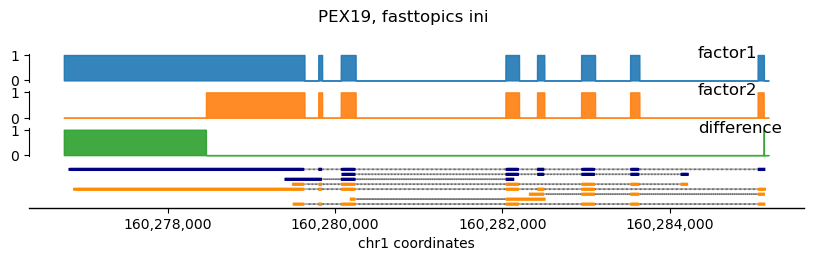

In [355]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000162735', 2)

plot_factors(corrected_EF, 2, 'ENSG00000162735', difference=True)


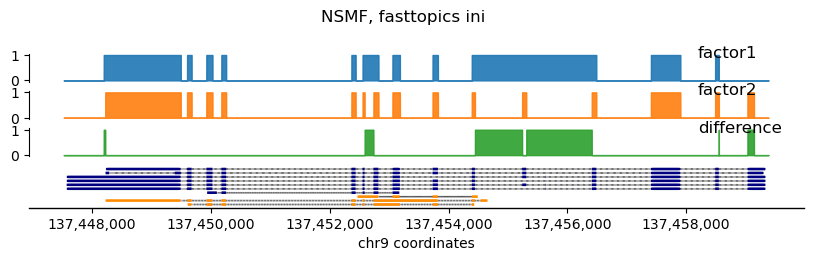

In [356]:


EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000165802', 2)

plot_factors(corrected_EF, 2, 'ENSG00000165802', difference=True)


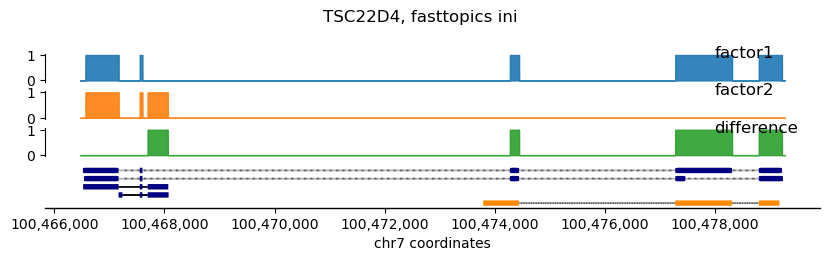

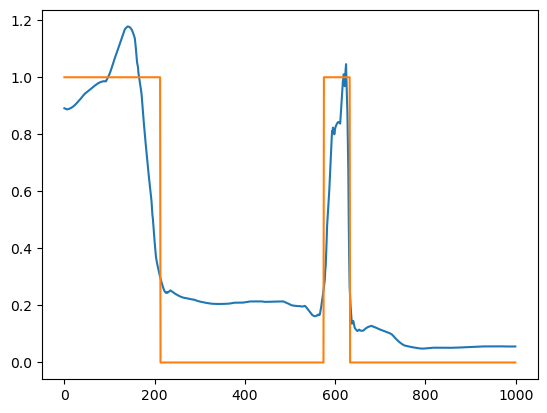

In [357]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000166925', 2)
plot_factors(corrected_EF, 2, 'ENSG00000166925', difference=True)

plt.plot(np.array(EF.factor1)[500:1500]/np.quantile(np.array(EF.factor1), 0.99))
plt.plot(np.array(EF_smooth.factor1)[500:1500])

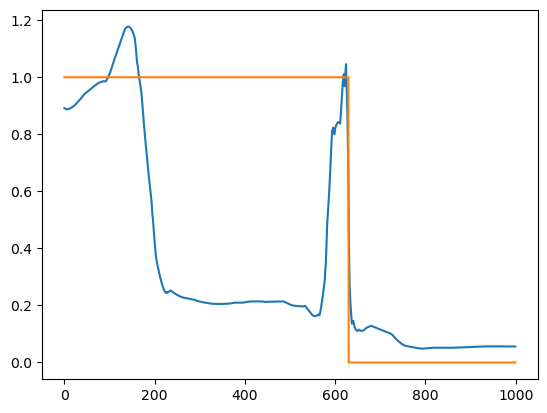

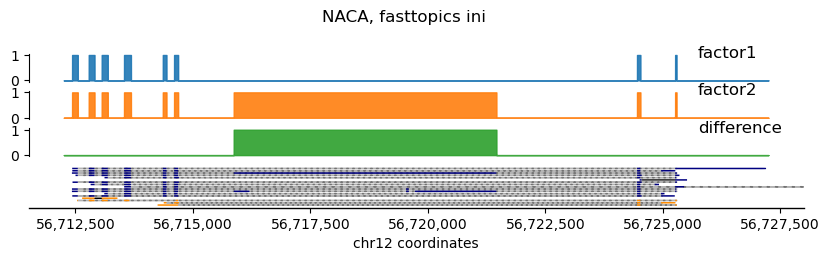

In [358]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000196531', 2)

plot_factors(corrected_EF, 2, 'ENSG00000196531', difference=True)


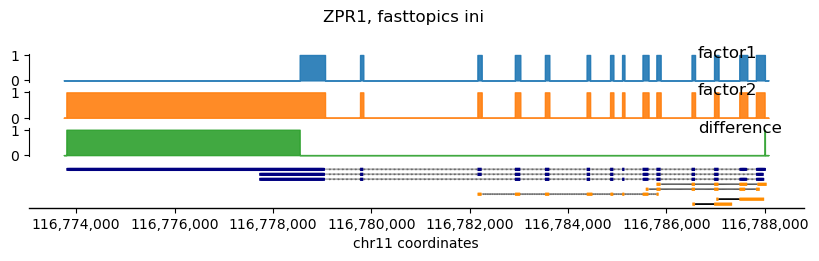

In [359]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000109917', 2)
plot_factors(corrected_EF, 2, 'ENSG00000109917', difference=True)


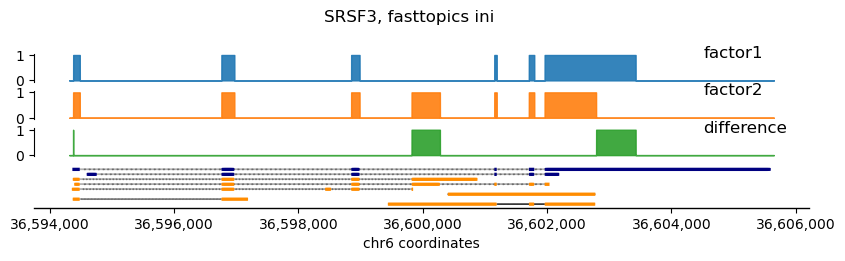

In [371]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000112081', 2)
plot_factors(corrected_EF, 2, 'ENSG00000112081', difference=True)


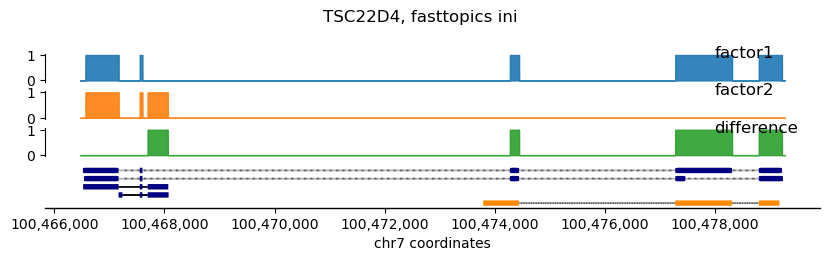

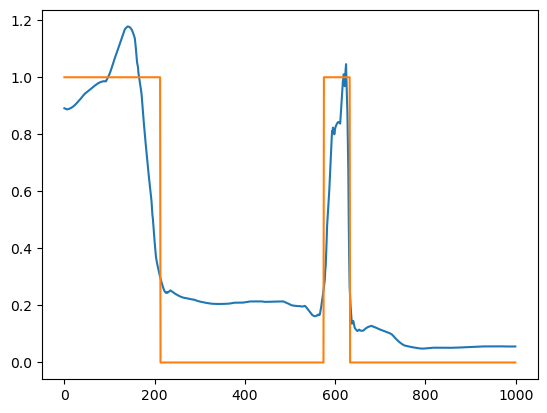

In [421]:
EF, EF_smooth, corrected_EF = get_factors_stm('ENSG00000166925', 2)
plot_factors(corrected_EF, 2, 'ENSG00000166925', difference=True)

plt.plot(np.array(EF.factor1)[500:1500]/np.quantile(np.array(EF.factor1), 0.99))
plt.plot(np.array(EF_smooth.factor1)[500:1500])

In [372]:
def make_factor_bed(EF, factor):
    EF_shift = (corrected_EF[factor].shift(-1).fillna(0) - corrected_EF[factor])
    EF_shift = EF_shift.loc[EF_shift != 0]
    
    chrom_list = []
    start_list = []
    end_list = []
    
    
    for idx, score in EF_shift.iteritems():
        chrom, pos = idx.split(':')
        if score == 1:
            start_list.append(int(pos))
            chrom_list.append(chrom)
        else:
            end_list.append(int(pos))
            
        
        
    isoform_df = pd.DataFrame()
    isoform_df['chrom'] = chrom_list
    isoform_df['start'] = start_list
    isoform_df['end'] = end_list
    isoform_df['length'] = isoform_df.end - isoform_df.start
    isoform_df['exon'] = range(1, len(chrom_list)+1)
    
    return isoform_df

In [422]:
EF_shift = (corrected_EF.factor1.shift(-1).fillna(0) - corrected_EF.factor1)

In [423]:
factor1_df = make_factor_bed(corrected_EF, 'factor1')
factor2_df = make_factor_bed(corrected_EF, 'factor2')

In [424]:
factor1_bed = BedTool.from_dataframe(factor1_df)
factor2_bed = BedTool.from_dataframe(factor2_df)

In [425]:
def classify_isoform(factor1, factor2):
    labels = []
    n = len(factor1)
    
    intersection = factor1.intersect(factor2, C=True)
    subtract = factor1.subtract(factor2)
    
    retained = []
    
    for i, row in enumerate(intersection):
        
        overlaps = int(row.fields[5])
        
        if overlaps == 0:
            if (i == 0) or (i == (n-1)):
                labels.append('alt first/last exon')
            else:
                labels.append('cassette exon')
                
        elif overlaps >= 2:
            labels.append('retained intron')
            retained.append(i)
            
    for row in subtract:
        size = row.end - row.start
        exon_length = int(row.fields[3])
        exon_no = int(row.fields[4])
        
        if (size == exon_length):
            continue
        
        elif ((size/exon_length) > 0.2) or (size > 100):
            if exon_no not in retained:
                if (exon_no == 1) or (exon_no == n):
                    labels.append('alt UTR')
                else:
                    print(exon_no)
                    labels.append('Alt SS')
                    
    if len(labels) == 0:
        labels.append('other')
    
    return labels

In [426]:
classify_isoform(factor1_bed, factor2_bed)

['cassette exon', 'cassette exon', 'alt first/last exon']

In [427]:
classify_isoform(factor2_bed, factor1_bed)

['alt first/last exon']

In [408]:
factor2_df

,chrom,start,end,length,exon
0,chr6,36594373,36594481,108,1
1,chr6,36596759,36596968,209,2
2,chr6,36598847,36598983,136,3
3,chr6,36599819,36600276,457,4
4,chr6,36601150,36601190,40,5
5,chr6,36601706,36601794,88,6
6,chr6,36601960,36602789,829,7


In [384]:
for i in factor1_bed.subtract(factor2_bed):
    print(i)

chr6	36602789	36603425	1465	6



In [385]:
for i in factor2_bed.subtract(factor1_bed):
    print(i)

chr6	36594373	36594374	108	1

chr6	36599819	36600276	457	4



In [306]:
EF_shift = (corrected_EF['factor1'].shift(-1).fillna(0) - corrected_EF['factor1'])
EF_shift = EF_shift.loc[EF_shift != 0]    

In [389]:
i.fields

['chr6', '36599819', '36600276', '457', '4']

In [362]:
for i in factor2_bed.intersect(factor1_bed, C=True):
    print(i)

chr6	36594373	36594481	108	1	1

chr6	36596759	36596968	209	2	1

chr6	36598847	36598983	136	3	1

chr6	36599819	36600276	457	4	0

chr6	36601150	36601190	40	5	1

chr6	36601706	36601794	88	6	1

chr6	36601960	36602789	829	7	1



In [370]:
for i in factor2_bed.intersect(factor1_bed, v=True, f = 0.99999):
    print(i)

chr6	36594373	36594481	108	1

chr6	36599819	36600276	457	4



In [365]:
i.fields

['chr6', '36601960', '36602789', '829', '7', '1']

In [310]:
for i in factor1_bed.intersect(factor2_bed, C=True):
    print(i)

chr6	36594374	36594481	107	1	1

chr6	36596759	36596968	209	2	1

chr6	36598847	36598983	136	3	1

chr6	36601150	36601190	40	4	1

chr6	36601706	36601794	88	5	1

chr6	36601960	36603425	1465	6	1



In [312]:
bed1 = pd.DataFrame(
    [
        ['chr1', 100, 200],
        ['chr1', 300, 400],
        ['chr1', 500, 600],
        ['chr1', 700, 800],
    ]
)

bed2 = pd.DataFrame(
    [
        ['chr1', 100, 200],
        ['chr1', 300, 600],
        ['chr1', 700, 800],
    ]
)

bed1 = BedTool.from_dataframe(bed1)
bed2 = BedTool.from_dataframe(bed2)

In [314]:
for i in bed1.intersect(bed2, C=True):
    print(i)

chr1	100	200	1

chr1	300	400	1

chr1	500	600	1

chr1	700	800	1



In [315]:
for i in bed2.intersect(bed1, C=True):
    print(i)

chr1	100	200	1

chr1	300	600	2

chr1	700	800	1

